Recovery in the Wishart model
---
We demostrate our recovery method for the spiked Wishart Model (PCA)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import importlib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [ ]:
import sys
PATH = '/content/gdrive/My Drive/Colab Notebooks/NEURIPS20'
sys.path.append(PATH)

In [ ]:
import generative as gnl
import utils
import spike_lib as spike

In [ ]:
importlib.reload(spike);

# Recovery

In [ ]:
# architecture
latent_dim = 15
hid_dim = 250 # hidden layer width
space_dim  = 1700 # ouptut dim
layers = [latent_dim, hid_dim, space_dim]

# Random Generative Network
GenNet = gnl.createRandGenNet(layers = layers, bias = False, Freeze = True).cuda()

# target latent vector
xstar = Variable(torch.zeros(latent_dim)) # the target point is zstar = e_2 
xstar.data[1] = 1
xstar = xstar.cuda()

# target vector in the range of G
ystar = GenNet(xstar);
xstar = xstar/ystar.norm(2) # scale it so that ystar is unit norm (use homogeneity)
ystar = GenNet(xstar);

In [ ]:
xstar

tensor([0.0000, 0.4671, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')

In [ ]:
# recovery param
Nsamples = 250 # samples 250 iid points from the spiked covariance model 
sigma = .5

# empirical covariance matrix
SigmaN = spike.spike_Covn(GenNet, xstar, Nsamples, sigma);
# empirical covariance minus noise part
M = SigmaN - (sigma**2)*torch.eye(len(ystar)).cuda();
# exact low rank component
Yts = torch.ger(ystar,ystar)

In [ ]:
#optimization params
Nsteps = 2500
LR  = 0.005
sigma0 = 0.0001 # we randomly initialize the iterates from x_0 \mathcal{N}(0, \sigma0^2 I)

In [ ]:
# defining the two starting points
z0 = sigma0*torch.randn(latent_dim).cuda()
z01 = Variable(z0, requires_grad=True);
z02 = Variable((-1.)*z0[:], requires_grad=True);

In [ ]:
%%time
[latent_param1, LOGS1] = spike.latent_GD(GenNet, M, Yts, z01, spike.frob_loss, ystar, learning_rate=LR, num_steps=Nsteps)

CPU times: user 3.47 s, sys: 378 ms, total: 3.85 s
Wall time: 3.91 s


In [ ]:
[latent_param2, LOGS2] = spike.latent_GD(GenNet, M, Yts, z02, spike.frob_loss, ystar, learning_rate=LR, num_steps=Nsteps)

Text(0.5, 0, 'Iterations')

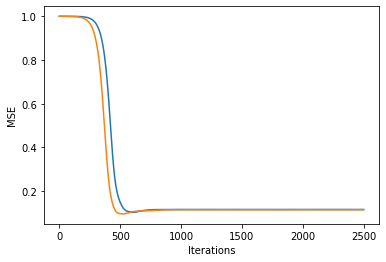

In [ ]:
plt.plot(LOGS1['l2_loss'])
plt.plot(LOGS2['l2_loss'])
plt.ylabel('MSE')
plt.xlabel('Iterations')

Final angle 0.9933673143386841


Text(0.5, 0, 'Iterations')

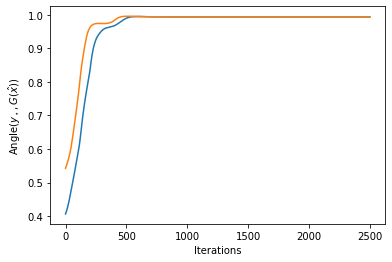

In [ ]:
plt.plot(LOGS1['angle_loss']);
plt.plot(LOGS2['angle_loss']);
print('Final angle', LOGS2['angle_loss'][-1]);
plt.ylabel(r'Angle($y_\star, G(\hat{x})$)');
plt.xlabel(r'Iterations')